<a href="https://colab.research.google.com/github/wdrdg/ML-model/blob/main/AlexNet_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Definition of our most effective model

In [ ]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Activation, MaxPooling2D
from keras.models import Model
from keras.layers import BatchNormalization as normalization
from keras.layers import concatenate,Dropout,Flatten

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.layers import LeakyReLU

num_classes        = 10         #分成多少类
batch_size         = 64         # 一个batch用64张图
iterations         = 782        #一个epoch用782个batch
epochs             = 50        #一共循环300个epoch        changed to 50 for now 0423
DROPOUT=0.5                     # 每个神经元以50%的概率失效
CONCAT_AXIS=3
weight_decay=1e-4
DATA_FORMAT='channels_last'     # Theano:'channels_first'  Tensorflow:'channels_last'
log_filepath  = './alexnet'     #tensorbroad的文件储存的路径

In [ ]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
def alexnet(img_input,activation_func,is_normalized,has_overlap_pool,has_dropout,struct=[1,1,1,1,1], classes=10):
    #struct defines the structure of alexnet; the ith element being '1' indicates that the ith convolutional layer is present
    x = img_input
    if struct[0]==1:
      x = Conv2D(96,(11,11),strides=(4,4),padding='same',
                activation=activation_func,kernel_initializer='uniform')(x)# valid
      if is_normalized : 
        x = normalization()(x)   #added normalization
      if has_overlap_pool:
        x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
      else:
        x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)

    if struct[1]==1:
      x = Conv2D(256,(5,5),strides=(1,1),padding='same',
                activation=activation_func,kernel_initializer='uniform')(x)
      if is_normalized : x = normalization()(x)   #added normalization
      if has_overlap_pool:
        x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
      else:
        x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)

    if struct[2]==1:
      x = Conv2D(384,(3,3),strides=(1,1),padding='same',
                activation=activation_func,kernel_initializer='uniform')(x) 
      if is_normalized : x = normalization()(x)   #added normalization


    if struct[3]==1:
      x = Conv2D(384,(3,3),strides=(1,1),padding='same',
                activation=activation_func,kernel_initializer='uniform')(x) 
      if is_normalized : x = normalization()(x)   #added normalization

    if struct[4]==1:
      x = Conv2D(256,(3,3),strides=(1,1),padding='same',
                activation=activation_func,kernel_initializer='uniform')(x)
      if is_normalized : x = normalization()(x)   #added normalization
      if has_overlap_pool: 
        x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
      else:
        x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    

    x = Flatten()(x)
    x = Dense(4096,activation=activation_func)(x)
    if has_dropout: x = Dropout(0.5)(x)
    x = Dense(4096,activation=activation_func)(x)
    if has_dropout: x = Dropout(0.5)(x)
    out = Dense(classes, activation='softmax')(x)
    return out

In [ ]:
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True)
model=Model(img_input,output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 96)          384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 256)         0   

# Training our best model

In [ ]:
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)

#horizontal_flip=True Randomly flip inputs horizontally. 随机翻转
# width_shift_range=0.125 水平平移，相对总宽度的比例
#height_shift_range=0.125 垂直平移，相对总高度的比例
#fill_mode='constant',cval=0 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k) 平移完用0来填充
datagen.fit(x_train)

In [ ]:
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)

#horizontal_flip=True Randomly flip inputs horizontally. 随机翻转
# width_shift_range=0.125 水平平移，相对总宽度的比例
#height_shift_range=0.125 垂直平移，相对总高度的比例
#fill_mode='constant',cval=0 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k) 平移完用0来填充
datagen.fit(x_train)

# start training
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
model.save('alexnet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
782/782 [==============================] - 59s 33ms/step - loss: 1.8794 - accuracy: 0.3201 - val_loss: 1.3808 - val_accuracy: 0.4997
Epoch 2/50
782/782 [==============================] - 25s 32ms/step - loss: 1.4182 - accuracy: 0.4898 - val_loss: 1.2620 - val_accuracy: 0.5478
Epoch 3/50
782/782 [==============================] - 25s 32ms/step - loss: 1.2779 - accuracy: 0.5411 - val_loss: 1.1426 - val_accuracy: 0.5992
Epoch 4/50
782/782 [==============================] - 25s 32ms/step - loss: 1.1862 - accuracy: 0.5763 - val_loss: 1.1079 - val_accuracy: 0.6084
Epoch 5/50
782/782 [==============================] - 25s 31ms/step - loss: 1.1214 - accuracy: 0.6042 - val_loss: 1.0277 - val_accuracy: 0.6437
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 1.0559 - accuracy: 0.6263 - val_loss: 1.0694 - val_accuracy: 0.6240
Epoch 7/50
782/782 [==============================] - 25s 32ms/step - loss: 1.0205 - accuracy: 0.6415 - val_loss: 0.9816 - val_accuracy:

In [ ]:
# Visualize History for Loss.
from matplotlib import pyplot as plt
import numpy as np
def err_from_acc(accs):
  return [1.0-acc for acc in accs]

print('The lowest error achieved on our model is: ' + str(np.min(err_from_acc(history.history['val_accuracy']))))

# Ablation Test

In [ ]:
#Testing the accuracy drop from removing the first convolutional layer
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True,struct=[0,1,1,1,1])
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_rem1 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_all_layers vs not_having_first is: ' + 
     str(100*np.min(err_from_acc(history_rem1.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#Testing the accuracy drop from removing the second convolutional layer
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True,struct=[1,0,1,1,1])
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_rem2 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_all_layers vs not_having_second is: ' + 
     str(100*np.min(err_from_acc(history_rem2.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#Testing the accuracy drop from removing the third convolutional layer
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True,struct=[1,1,0,1,1])
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_rem3 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_all_layers vs not_having_third is: ' + 
     str(100*np.min(err_from_acc(history_rem3.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#Testing the accuracy drop from removing the fourth convolutional layer
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True,struct=[1,1,1,0,1])
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_rem4 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_all_layers vs not_having_fourth is: ' + 
     str(100*np.min(err_from_acc(history_rem4.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#Testing the accuracy drop from removing the fifth convolutional layer
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True,struct=[1,1,1,1,0])
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_rem5 = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_all_layers vs not_having_fifth is: ' + 
     str(100*np.min(err_from_acc(history_rem5.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

# Reproducing the experiments in the AlexNet paper

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
782/782 [==============================] - 27s 33ms/step - loss: 2.2798 - accuracy: 0.2652 - val_loss: 1.6780 - val_accuracy: 0.4049
Epoch 2/50
782/782 [==============================] - 25s 32ms/step - loss: 1.6288 - accuracy: 0.3984 - val_loss: 1.6066 - val_accuracy: 0.4179
Epoch 3/50
782/782 [==============================] - 25s 32ms/step - loss: 1.5269 - accuracy: 0.4463 - val_loss: 1.4354 - val_accuracy: 0.4846
Epoch 4/50
782/782 [==============================] - 25s 32ms/step - loss: 1.4494 - accuracy: 0.4789 - val_loss: 1.4709 - val_accuracy: 0.4716
Epoch 5/50
782/782 [==============================] - 25s 32ms/step - loss: 1.3926 - accuracy: 0.4952 - val_loss: 1.2790 - val_accuracy: 0.5371
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 1.3332 - accuracy: 0.5217 - val_loss: 1.3073 - val_accuracy: 0.5370
Epoch 7/50
782/782 [==============================] - 25s 32ms/step - loss: 1.3124 - accuracy: 0.5295 - val_loss: 1.2750 - val_accuracy:

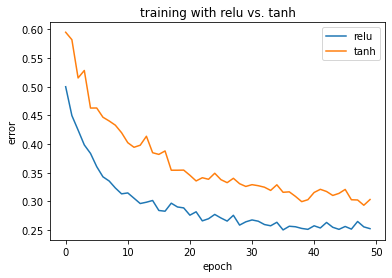

In [ ]:
#3.1 ReLU-activated CNN takes less time to reach 25% training error than CNNs with saturating non-linearity
#First define Alexnet but with tanh activation function
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'tanh',True,True,True)   #Activation, lrn, Overlap, Dropout
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_tanh = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
plt.title('training with relu vs. tanh')
plt.plot(err_from_acc(history.history['val_accuracy']))
plt.plot(err_from_acc(history_tanh.history['val_accuracy']))
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['relu', 'tanh'])
plt.show()

In [ ]:
#3.2 accuracy improvement after adding Local Reponse Normalization
#build a model with every setting being the same but LRN removed
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',False,True,True)
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_lrn = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result for 3.2
print('Accuracy improvement in having_lrn vs not_having_lrn is: ' + 
     str(100*np.min(err_from_acc(history_lrn.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#3.3 accuracy improvement for having overlapping pooling
#build a model with every setting being the same but NO overlapping pooling
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,False,True)
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
hisotry_overlap = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_overlap vs not_having_overlap is: ' + 
     str(100*np.min(err_from_acc(hisotry_overlap.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#4.1 data augmentation vs no data augmentation
#build a model with every setting being the same but trained with NO data augmentation
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,True)
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_augmentation = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    steps_per_epoch=iterations,
    epochs=epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    callbacks=cbks,
    validation_data=(x_test, y_test),
)
#displaying the result
print('Accuracy improvement in having_augmentation vs not_having_augmentation is: ' + 
     str(100*np.min(err_from_acc(history_augmentation.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
#4.2 dropout vs no dropout
#build a model with every setting being the same but NO dropout
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,'relu',True,True,False)
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
hisotry_dropout = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_dropout vs not_having_dropout is: ' + 
     str(100*np.min(err_from_acc(hisotry_dropout.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )

In [ ]:
# leaky relu vs relu
# build a model with every setting being the same but using leaky relu as activation
img_input=Input(shape=(32,32,3))
output = alexnet(img_input,LeakyReLU(),True,True,False)
model=Model(img_input,output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
hisotry_dropout = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
#displaying the result
print('Accuracy improvement in having_dropout vs not_having_dropout is: ' + 
     str(100*np.min(err_from_acc(hisotry_dropout.history['val_accuracy'])) - 100*np.min(err_from_acc(history.history['val_accuracy']))) 
     + ' percent' )